#**UFC Fight Outcome Prediction Using Random Forest**

##**Step 1: Install and Import Libraries**

In [1]:
# Install necessary libraries (if not already installed)
!pip install pandas numpy scikit-learn seaborn matplotlib

In [3]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
from IPython.display import display,  HTML
import seaborn as sns
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import the Random Forest model
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE

##**Step 2: Load and Prepare Data**

In [4]:
# Load from local directory if uploaded to Colab
original_df = pd.read_csv('ufc-master.csv')

# Preview the data
original_df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Neil Magny,Carlos Prates,550.0,-800.0,550.0000,12.5000,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,Punch,1.0,4:50,290.0,1100.0,800.0,1600.0,800.0,2000.0,-400.0
1,Gerald Meerschaert,Reinier de Ridder,250.0,-310.0,250.0000,32.2581,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,Arm Triangle,3.0,1:44,704.0,700.0,200.0,600.0,165.0,1400.0,450.0
2,Gaston Bolanos,Cortavious Romious,205.0,-250.0,205.0000,40.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,550.0,275.0,3000.0,165.0,380.0,450.0
3,Luana Pinheiro,Gillian Robertson,360.0,-470.0,360.0000,21.2766,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,600.0,250.0,2200.0,110.0,900.0,500.0
4,Mansur Abdul-Malik,Dusko Todorovic,-485.0,370.0,20.6186,370.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,Punches,1.0,2:44,164.0,600.0,NaN,800.0,NaN,-250.0,NaN


##**Step 3: Data Cleaning and Feature Engineering**

In [5]:
# Load the original dataset again
df = pd.read_csv('ufc-master.csv')

###**3.1 Handle Missing Values**

In [6]:
# Calculate the percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Create a DataFrame to display the results
missing_table = pd.DataFrame({
    'Column': missing_percentages.index,
    'Missing Percentage': missing_percentages.values
})

# Sort the table by missing percentage in descending order
missing_table = missing_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table nicely in Jupyter Notebook
display(missing_table)

,Column,Missing Percentage
94,BWFeatherweightRank,99.984589
81,RWFeatherweightRank,99.861304
105,BPFPRank,98.967483
93,BWFlyweightRank,98.890430
80,RWFlyweightRank,98.520573
...,...,...
46,RedLosses,0.000000
45,RedLongestWinStreak,0.000000
39,RedDraws,0.000000
38,RedCurrentWinStreak,0.000000


In [7]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Impute categorical columns with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
# Verify Missing Values Are Handled
missing_values = df.isnull().sum()

# Convert to a DataFrame for better display
missing_values_df = pd.DataFrame({
    "Column": missing_values.index,
    "Missing Values": missing_values.values
})

# Display the missing values as a table
display(HTML("<b>Missing values after handling:</b>"))
display(missing_values_df)

,Column,Missing Values
0,RedFighter,0
1,BlueFighter,0
2,RedOdds,0
3,BlueOdds,0
4,RedExpectedValue,0
...,...,...
113,BlueDecOdds,0
114,RSubOdds,0
115,BSubOdds,0
116,RKOOdds,0


###**3.2 Encode Categorical Variables**

In [9]:
# Define categorical features to encode
categorical_features = ['RedFighter', 'BlueFighter', 'Location', 'Country','WeightClass', 'TitleBout', 'Gender',  'Winner',  'BlueStance',  'RedStance', 'BetterRank',  'Finish', 'FinishDetails', 'FinishRoundTime']

# Initialize LabelEncoder
le = LabelEncoder()

# Encode categorical features
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Preview encode data
df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,1185,279,550.0,-800.0,550.0000,12.5000,2024-11-09,68,32,0,...,26,1.0,283,290.0,1100.0,800.000000,1600.0,800.000000,2000.0,-400.000000
1,557,1510,250.0,-310.0,250.0000,32.2581,2024-11-09,68,32,0,...,2,3.0,97,704.0,700.0,200.000000,600.0,165.000000,1400.0,450.000000
2,548,386,205.0,-250.0,205.0000,40.0000,2024-11-09,68,32,1,...,26,3.0,293,900.0,550.0,275.000000,3000.0,165.000000,380.0,450.000000
3,973,662,360.0,-470.0,360.0000,21.2766,2024-11-09,68,32,0,...,26,3.0,293,900.0,600.0,250.000000,2200.0,110.000000,900.0,500.000000
4,1017,531,-485.0,370.0,20.6186,370.0000,2024-11-09,68,32,1,...,27,1.0,157,164.0,600.0,424.888372,800.0,1096.948168,-250.0,634.561879


###**3.3 Define Features and Targets**

In [10]:
# Define features (exclude target and unnecessary columns)
X = df.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)

# Define targets
y_winner = df['Winner']
y_method = df['Finish']
y_round = pd.to_numeric(df['FinishRound'], errors='coerce').fillna(0).astype(int)

###**3.4 Correlation Analysis**

,Feature,Correlation
0,Winner,1.000000
1,BlueOdds,0.342837
2,BlueExpectedValue,0.312240
3,BlueDecOdds,0.210757
4,BKOOdds,0.184310
...,...,...
112,RKOOdds,-0.176841
113,RedExpectedValue,-0.317071
114,RedOdds,-0.335636
115,RWFeatherweightRank,NaN


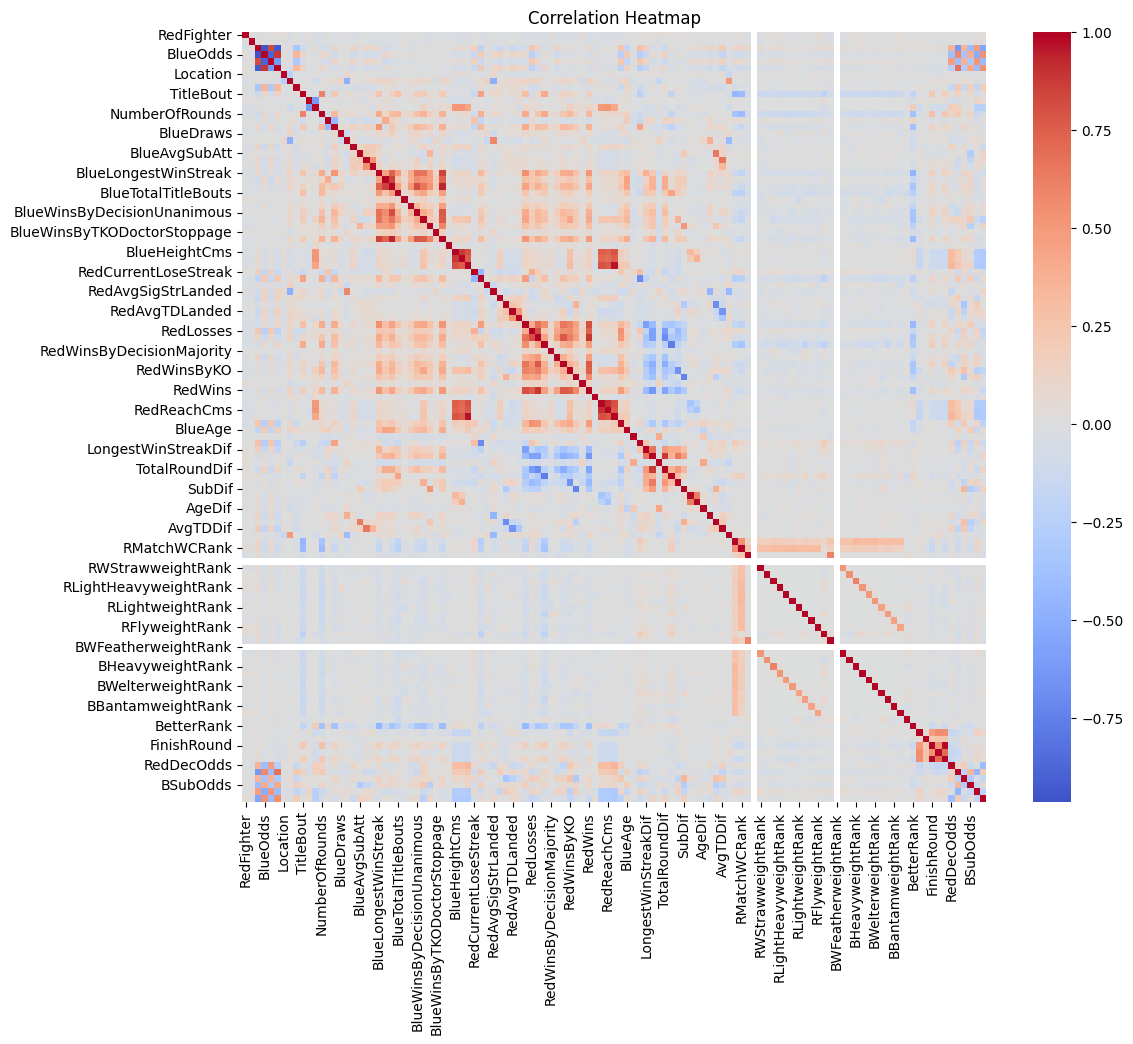

In [11]:
# Compute the correlation matrix, excluding non-numeric columns
corr_matrix = df.select_dtypes(include=np.number).corr()

# Extract correlations with the target variable 'Winner'
target_corr = corr_matrix['Winner'].sort_values(ascending=False)

# Display the correlations as a table
display(HTML("<b>Correlation of features with target variable 'Winner':</b>"))
target_corr_df = target_corr.reset_index().rename(columns={'index': 'Feature', 'Winner': 'Correlation'})
display(target_corr_df)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

##**Step 4: Split Data Based on Date**

###**4.1 Define Cut-off Dates**

In [12]:
# Define the cut-off date for training and testing
train_end_date = pd.to_datetime('2024-03-31')
test_start_date = pd.to_datetime('2024-04-01')

###**4.2 Split the Data**

In [13]:
df['Date'] = pd.to_datetime(df['Date'])

# Create training data: fights up to March 31, 2024
df_train = df[df['Date'] <= train_end_date]

# Create testing data: fights from April 1, 2024 onwards
df_test = df[df['Date'] >= test_start_date]

# Create a summary DataFrame
data_summary = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Number of Records': [len(df_train), len(df_test)]
})

# Display the summary as a table
display(data_summary)

,Dataset,Number of Records
0,Training,6163
1,Testing,326


###**4.3 Prepare Features and Targets for Training and Testing**

In [14]:
# Features and targets for training data
X_train = df_train.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)
y_train_winner = df_train['Winner']
y_train_method = df_train['Finish']
y_train_round = pd.to_numeric(df_train['FinishRound'], errors='coerce').fillna(0).astype(int)

# Features and targets for testing data
X_test = df_test.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)
y_test_winner = df_test['Winner']
y_test_method = df_test['Finish']
y_test_round = pd.to_numeric(df_test['FinishRound'], errors='coerce').fillna(0).astype(int)

In [15]:
# Display the X training data
display(HTML("<b>X Training Data:</b>"))
X_train.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
326,506,1175,-218.0,180.0,45.8716,180.0000,7,32,0,11,...,1,26,293,1500.0,225.0,300.0,180.0,2800.0,800.0,500.0
327,1569,867,-148.0,124.0,67.5676,124.0000,7,32,0,8,...,1,27,190,497.0,500.0,300.0,450.0,2500.0,250.0,240.0
328,295,244,145.0,-175.0,145.0000,57.1429,7,32,0,7,...,2,26,131,738.0,400.0,450.0,500.0,1600.0,1200.0,-110.0
329,1213,1636,-258.0,210.0,38.7597,210.0000,7,32,0,7,...,2,26,191,198.0,800.0,550.0,150.0,1000.0,250.0,400.0
330,171,1076,-298.0,240.0,33.5570,240.0000,7,32,0,2,...,2,27,233,240.0,120.0,300.0,400.0,1800.0,450.0,1000.0


In [16]:
# Display the X test data
display(HTML("<b>X Test Data:</b>"))
X_test.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,1185,279,550.0,-800.0,550.0000,12.5000,68,32,0,8,...,1,26,283,290.0,1100.0,800.000000,1600.0,800.000000,2000.0,-400.000000
1,557,1510,250.0,-310.0,250.0000,32.2581,68,32,0,7,...,2,2,97,704.0,700.0,200.000000,600.0,165.000000,1400.0,450.000000
2,548,386,205.0,-250.0,205.0000,40.0000,68,32,0,0,...,2,26,293,900.0,550.0,275.000000,3000.0,165.000000,380.0,450.000000
3,973,662,360.0,-470.0,360.0000,21.2766,68,32,0,12,...,1,26,293,900.0,600.0,250.000000,2200.0,110.000000,900.0,500.000000
4,1017,531,-485.0,370.0,20.6186,370.0000,68,32,0,7,...,2,27,157,164.0,600.0,424.888372,800.0,1096.948168,-250.0,634.561879


###**4.4 Scale Features**

In [17]:
# Initialize scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the features using the previously fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Convert scaled training data back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Display the scaled training DataFrames
display(HTML("<b>Scaled Training Data:</b>"))
display(X_train_scaled_df)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,-0.654674,0.426359,-0.381414,0.479980,-0.599424,0.111045,-1.768143,1.093322,-0.221004,1.732085,...,-1.448556,0.326325,0.712938,2.475694,-0.359016,-0.427773,-1.312647,2.898319,0.784097,-0.328489
1,1.588769,-0.130970,-0.121489,0.253714,-0.340326,-0.304753,-1.768143,1.093322,-0.221004,0.788022,...,-1.448556,0.476916,-0.447625,-0.459508,0.855953,-0.427773,-0.802940,2.388854,-0.696937,-0.964648
2,-1.099985,-1.258295,0.966483,-0.954382,0.584389,-0.801163,-1.768143,1.093322,-0.221004,0.473334,...,0.607040,0.326325,-1.112413,0.245760,0.414146,0.088148,-0.708550,0.860460,1.861212,-1.821015
3,0.837438,1.260544,-0.529942,0.601193,-0.684356,0.333793,-1.768143,1.093322,-0.221004,0.473334,...,0.607040,0.326325,-0.436358,-1.334508,2.181374,0.432096,-1.369281,-0.158470,-0.696937,-0.573165
4,-1.361685,0.247218,-0.678471,0.722407,-0.746487,0.556542,-1.768143,1.093322,-0.221004,-1.100105,...,0.607040,0.476916,0.036882,-1.211599,-0.822913,-0.427773,-0.897330,1.200103,-0.158379,0.894894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6158,-0.755977,-0.865631,-0.147481,0.298159,-0.376767,-0.223078,-1.248788,-0.005658,-0.221004,0.158646,...,0.607040,0.326325,-2.171568,-1.785178,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6159,-0.089064,-0.914488,-0.351708,0.459777,-0.578556,0.073920,-1.248788,-0.005658,-0.221004,0.788022,...,0.607040,0.326325,-1.303963,-1.559843,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6160,-1.302592,-1.133438,-0.537369,0.641598,-0.687917,0.408043,-1.248788,-0.005658,-0.221004,-0.470730,...,0.607040,0.476916,-2.137765,-1.776398,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6161,0.662268,0.080743,-1.131483,1.106251,-0.862894,1.261912,-1.248788,-0.005658,-0.221004,0.788022,...,0.607040,0.326325,0.712938,0.719840,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753


In [19]:
# Convert scaled test data back to DataFrames
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display the scaled test DataFrames
display(HTML("<b>Scaled Test Data:</b>"))
display(X_test_scaled_df)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,0.778344,-1.194962,2.470334,-3.479668,5.420986,-1.132635,-0.100738,1.093322,-0.221004,0.788022,...,-1.448556,0.326325,0.600262,-1.065278,3.506795,1.291965,1.368034,-0.498113,4.015444,-2.530577
1,-0.547039,1.032545,1.356370,-1.499844,1.838321,-0.985932,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,-3.287860,-1.495512,0.146261,1.739567,-0.771721,-0.519770,-1.576480,2.399770,-0.450827
2,-0.566033,-1.001344,1.189276,-1.257417,1.300922,-0.928448,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,0.326325,0.712938,0.719840,1.076857,-0.513760,4.010960,-1.576480,-0.346875,-0.450827
3,0.330922,-0.501919,1.764824,-2.146317,3.151965,-1.067469,-0.100738,1.093322,-0.221004,2.046773,...,-1.448556,0.326325,0.712938,0.719840,1.297760,-0.599747,2.500717,-1.669882,1.053376,-0.328489
4,0.423783,-0.738965,-1.372842,1.247667,-0.901001,1.521785,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,0.476916,-0.819456,-1.434007,1.297760,0.001777,-0.142209,0.006169,-2.043332,0.000753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.833217,-0.516395,0.001047,-0.671550,-0.108779,-0.518308,-0.100738,1.093322,-0.221004,1.102710,...,-1.448556,0.326325,0.712938,0.719840,-0.867094,-0.634142,0.046572,1.200103,3.476886,-0.695503
322,0.919746,1.602541,0.910785,-0.873573,0.405256,-0.746418,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,0.326325,0.712938,0.719840,0.414146,-0.599747,-0.614160,-1.347221,-0.293019,-0.450827
323,-0.950141,-0.221445,0.910785,-0.873573,0.405256,-0.746418,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,-2.233722,0.701670,-0.161013,0.008656,-1.012484,0.016594,-0.837756,0.004167,-0.083812
324,-0.732761,-1.175057,-0.188327,0.318361,-0.427821,-0.185953,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,-2.685496,-1.168751,-0.646799,-0.624100,-0.513760,-0.802940,1.539746,-0.023740,-0.511996


##**Step 5: Model Training**

###**5.1 Winner Prediction Model**

In [20]:
# Train the winner model
winner_model = RandomForestClassifier(random_state=42)
winner_model.fit(X_train_scaled, y_train_winner)

RandomForestClassifier(random_state=42)

###**5.2 Feature Importance from Random Forest**

In [21]:
# Extract feature importances
importances = winner_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Define the list of feature counts you want to display
feature_counts = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

# Create a dictionary to store the top features for each feature count
feature_table = {}

for count in feature_counts:
    # Select the top `count` features
    top_features = feature_importance_df.head(count)['Feature'].values
    # Store the features in the dictionary
    feature_table[count] = top_features

# Convert the dictionary to a DataFrame
feature_table_df = pd.DataFrame.from_dict(feature_table, orient='index').transpose()

# Display the table
display(HTML(f"<h3>Feature Importance Table:</h3>"))
display(feature_table_df)

"""
# Display plots for each feature count
for count in feature_counts:
    display(HTML(f"<h3>Top {count} Important Features for Winner Prediction:</h3>"))
    # Plot the top N feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(count))
    plt.title(f'Top {count} Important Features for Winner Prediction')
    plt.show()
"""

,20,25,30,35,40,45,50,55,60,65,70,75,80,85
0,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue
1,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue,BlueExpectedValue
2,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds
3,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds
4,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds,BlueDecOdds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,None,None,None,None,None,None,None,None,None,None,None,None,None,NumberOfRounds
81,None,None,None,None,None,None,None,None,None,None,None,None,None,RMiddleweightRank
82,None,None,None,None,None,None,None,None,None,None,None,None,None,RLightweightRank
83,None,None,None,None,None,None,None,None,None,None,None,None,None,BLightweightRank


'\n# Display plots for each feature count\nfor count in feature_counts:\n    display(HTML(f"<h3>Top {count} Important Features for Winner Prediction:</h3>"))\n    # Plot the top N feature importances\n    plt.figure(figsize=(12, 8))\n    sns.barplot(x=\'Importance\', y=\'Feature\', data=feature_importance_df.head(count))\n    plt.title(f\'Top {count} Important Features for Winner Prediction\')\n    plt.show()\n'

###**5.3 Retrain Model with Top Features**

In [22]:
# Initialize a dictionary to store accuracy for each feature count
accuracy_results = {}

for count in feature_counts:
    # Get the top `count` features
    top_features = feature_importance_df['Feature'].head(count).values

    # Update X_train and X_test with selected features using .loc[] for column selection
    X_train_top_scaled = X_train_scaled[:, X_train.columns.get_indexer(top_features)]
    X_test_top_scaled = X_test_scaled[:, X_test.columns.get_indexer(top_features)]

    # Retrain the model
    winner_model_top = RandomForestClassifier(random_state=42)
    winner_model_top.fit(X_train_top_scaled, y_train_winner)

    # Make predictions
    y_pred_winner_top = winner_model_top.predict(X_test_top_scaled)

    # Evaluate the model
    accuracy_winner_top = accuracy_score(y_test_winner, y_pred_winner_top)
    accuracy_results[count] = accuracy_winner_top

# Convert the accuracy results to a DataFrame for display
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Number of Features', 'Accuracy'])

# Display the results
accuracy_df.set_index('Number of Features', inplace=True)
display(accuracy_df)

,Accuracy
Number of Features,
20,0.650307
25,0.653374
30,0.662577
35,0.668712
40,0.687117
45,0.647239
50,0.647239
55,0.687117
60,0.690184


###**5.4 Recursive Feature Elimination (RFE)**

In [23]:
# Define the list of feature counts you want to display
feature_counts_rfe = [40, 45, 50, 55, 60, 65, 70]

# Initialize lists to store results
rfe_results = []
features_dict = {}

for count in feature_counts_rfe:
    # Initialize RFE with the desired number of features
    rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=count)
    rfe.fit(X_train_scaled, y_train_winner)

    # Get the selected features
    selected_features = X_train.columns[rfe.support_]
    features_dict[count] = selected_features  # Store features for this count

    # Update training and testing data
    X_train_rfe = X_train_scaled[:, rfe.support_]
    X_test_rfe = X_test_scaled[:, rfe.support_]

    # Retrain the model
    winner_model_rfe = RandomForestClassifier(random_state=42)
    winner_model_rfe.fit(X_train_rfe, y_train_winner)

    # Make predictions
    y_pred_winner_rfe = winner_model_rfe.predict(X_test_rfe)

    # Evaluate the model
    accuracy_winner_rfe = accuracy_score(y_test_winner, y_pred_winner_rfe)

    # Store the results
    rfe_results.append({
        'Number of Features': count,
        'Accuracy': accuracy_winner_rfe
    })

# Convert accuracy results to a DataFrame
rfe_results_df = pd.DataFrame(rfe_results)

# Convert features_dict to a DataFrame
features_df = pd.DataFrame.from_dict(features_dict, orient='index').transpose()

# Display the results
display(HTML(f"<h3>Accuracy Results:</h3>"))
display(rfe_results_df)

display(HTML(f"<h3>Selected Features:</h3>"))
display(features_df)

,Number of Features,Accuracy
0,40,0.690184
1,45,0.668712
2,50,0.668712
3,55,0.687117
4,60,0.662577
5,65,0.680982
6,70,0.662577


,40,45,50,55,60,65,70
0,RedFighter,RedFighter,RedFighter,RedFighter,RedFighter,RedFighter,RedFighter
1,BlueFighter,BlueFighter,BlueFighter,BlueFighter,BlueFighter,BlueFighter,BlueFighter
2,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds,RedOdds
3,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds,BlueOdds
4,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue,RedExpectedValue
...,...,...,...,...,...,...,...
65,None,None,None,None,None,None,BlueDecOdds
66,None,None,None,None,None,None,RSubOdds
67,None,None,None,None,None,None,BSubOdds
68,None,None,None,None,None,None,RKOOdds


##**Step 6: Select and save best features**

In [24]:
# Select features calculated from RFE with 40 features
selected_features_40 = features_dict[40]

# Filter the original DataFrame to include only the selected features
filtered_df = original_df[selected_features_40]

# Save the filtered DataFrame to a CSV file
filtered_df.to_csv('filtered_data_40_features.csv', index=False)

# Save the selected feature names to a CSV file
pd.DataFrame(selected_features_40, columns=['Selected Features']).to_csv('selected_features_40.csv', index=False)

# Display the message with the number of features
display(HTML(f"<h3>Filtered DataFrame with {len(selected_features_40)} features saved as 'filtered_data_40_features.csv'</h3>"))
display(HTML(f"<h3>Selected feature names saved as 'selected_features_40.csv'</h3>"))

# Display the filtered DataFrame
display(filtered_df.head())

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,BlueAvgSigStrLanded,BlueAvgSigStrPct,BlueAvgTDLanded,...,AvgSubAttDif,AvgTDDif,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Neil Magny,Carlos Prates,550.0,-800.0,550.0000,12.5000,"Las Vegas, Nevada, USA",4.39,0.57,0.44,...,-0.2,-1.68,4:50,290.0,1100.0,800.0,1600.0,800.0,2000.0,-400.0
1,Gerald Meerschaert,Reinier de Ridder,250.0,-310.0,250.0000,32.2581,"Las Vegas, Nevada, USA",3.24,0.57,6.39,...,-0.2,4.38,1:44,704.0,700.0,200.0,600.0,165.0,1400.0,450.0
2,Gaston Bolanos,Cortavious Romious,205.0,-250.0,205.0000,40.0000,"Las Vegas, Nevada, USA",2.10,0.37,1.97,...,1.0,1.19,5:00,900.0,550.0,275.0,3000.0,165.0,380.0,450.0
3,Luana Pinheiro,Gillian Robertson,360.0,-470.0,360.0000,21.2766,"Las Vegas, Nevada, USA",2.89,0.48,2.68,...,0.8,0.88,5:00,900.0,600.0,250.0,2200.0,110.0,900.0,500.0
4,Mansur Abdul-Malik,Dusko Todorovic,-485.0,370.0,20.6186,370.0000,"Las Vegas, Nevada, USA",5.35,0.57,0.92,...,0.0,0.92,2:44,164.0,600.0,NaN,800.0,NaN,-250.0,NaN
